In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions,preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


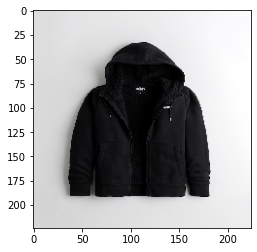

In [6]:
img, x = load_image("test.jpeg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [7]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))



predicted sweatshirt with probability 0.340
predicted ski_mask with probability 0.100
predicted bulletproof_vest with probability 0.084
predicted wool with probability 0.043
predicted gasmask with probability 0.039


In [8]:
sim = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
sim.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

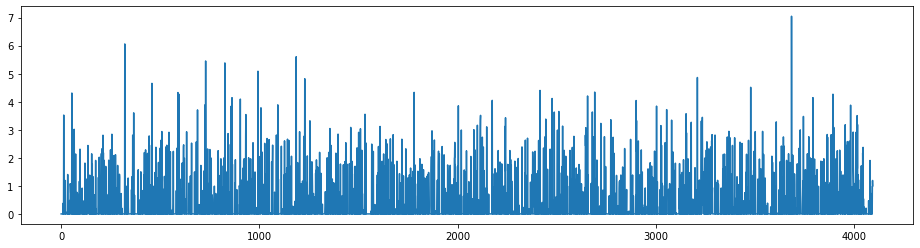

In [9]:
img, x = load_image("test.jpeg")
feat = sim.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [10]:
images_path = 'Images'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 150 images to analyze


In [11]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = sim.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 150. Time: 0.0006 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


finished extracting features for 150 images


In [12]:
feat.shape

(4096,)

In [13]:
len(features)


150

In [14]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=150)
pca.fit(features)

PCA(n_components=150)

In [15]:
pca_features = pca.transform(features)

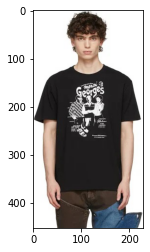

In [16]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [17]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [18]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

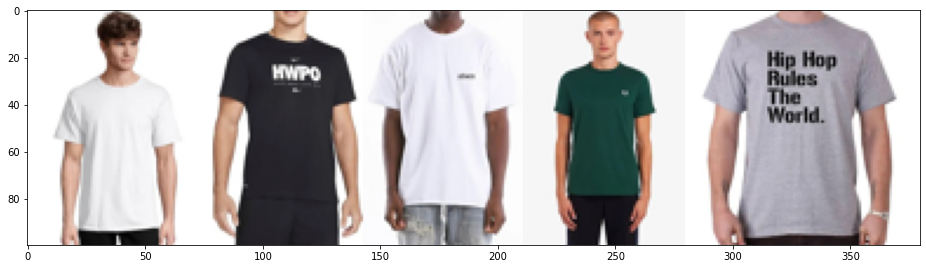

In [19]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [20]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

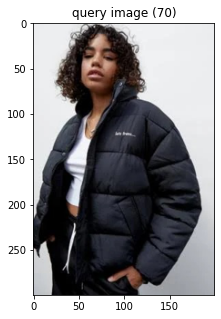

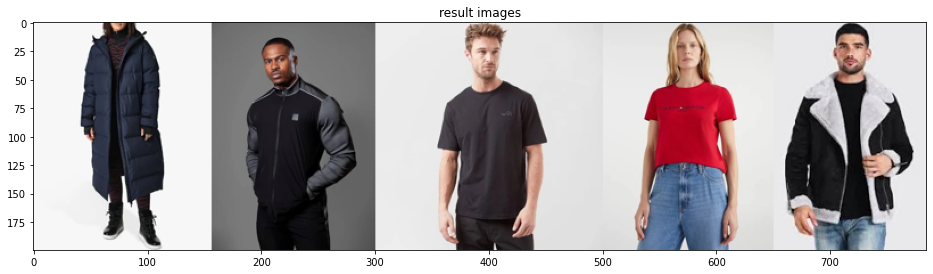

In [21]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [22]:
##Converting base64 to jpeg

In [23]:
png_b64text6= '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAD8APwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD180ClooAUU6minUAOFOpop1AARmgDFBOKAc0AFKKSlFAC4o6UVHJIAvWgBWkCjNVZbkAk5qrc3qrn5q8x8b/EZtNlfTtJZXvh/rZWwVgz7d29u1AHoOqeItP0mLzb+9ht0PTzHwW+g6n8K4bV/jHZ2ysumWr3DdpJsxp+A+8f0rxm5v5ru6e4nnkuLl/vSysWY1VkVy2WJJNAHdr8UPEs+sLfDUmXbx9nH+px6bP69fevVPDXxU03V/Lg1FVspjgB9+Yj9Sfu/jx7183qj9QpqzA1wrhl+VhyDmgD7HB7jp1B9aeDXhXgP4i3OjwpY6oWnsl4BHLxD29R7flXtlle21/aRXVpMk0Ei7kkQ5BFAF0U4VGGp6nNMB4paQUtABT6ZT6AHUUUUAFFLRQAUUtFIDBooooAUU4CminigBwpabSigBaKKKAClFJTHfaKAFklCLz1rIvb0Ip54p97eKinmvP/ABh4pXR9Nef70zHZDH/fb/DvQBlePfHR0xDY2L5vpV5Yc+Uvr7sew/GvGpp3YnJJckliTnk9c+/vU9xO0txJc3U3mXMrFpGJycmofMTHyxk++KAIY2KYJ/CrSu5FVmV2OQp/Gnp5qjhf1oGTGRwcE0+O5KsMiog56MhB9qaygk4VvbigDoLeUSruVsMK6zwh4yvvC1+G5lsZCPOt89R6r6N/OvO4ZNnG4gjvV+G+ccMQ31NAH1rp2oWuqWMN7ZzCW2mXcjjv/gfarynFeA/DnxqdCvPstw7Npk7fOvUwv/fGOo6Z/PtXvSOrqGUhlPIIOQR7UCLApajDVIKYCinio6eKAFpaKUUAFFLRSAKKKKAMGiiigBwp4pgpwoAWlFJSigBaKKKAGu20ZrMvLsKpwauXUhVCa5XUbrkjNAGdrut2+n2kt1dzrFDGMs7fy9z7V4b4o8TNrmoGdUZbWMbYhIeQO5+pwP0qx4y8QSa9rJjRz9htWKRLnhj/ABOf6e31rjrmUSzEqTsHCg0ATteLnIP5CmG7BPOaqUmKALf2oD+E05LznAUn8apUo65oAvNernBQil+1xkYyRVIsG6jn2ptAGkt4irw5z3wKcNRQfxv+ArLFWBD5mBHgH0NAGgms7CCrPkHg4r1DwP8AGSbRxBpupJ9q09OFdeJYh7c4I9q8dmga3IDdTUIJByDzQB9z2F/a6lYw3tlOk9vMgdJE6Ef0q6pyK8Q/Z/8AEElzZ6jocrlhDi4hHoDww/PafxNe2rQBLThTacKAFp1Np4oAKKKWgBKXFFFAHPinAUlOzQAU6kFLQAop1NFOoAKKQnFV5p1jXJNAFbUJMIRmuD8RTsmn3rofnWByv1wa6TUb8YIzXJalKs6SRMchlKn8aAPn67Zo0jUHjaRVGtC9haNPKb/WQsUYe44P8qz6AYCpRH8gPvTFyOR2qeSbZ8gRc7fvfUUAV2xnjp2pKVSR0oDEdaAG0Up5OaSgBRU6FshlOMVXqaEjdznHtQBa1B2khgdsbmBzgelUKuTOJFxgkjp7VPYaXPezxwwx7pZGCIhIG4n3PA/GgD2H9niwm+3azqBXEKwxwBv9oncR+Sj869+WuY8EeFofCPhi20xCry/6y4lUcSSHrj2HAHsK6ZDg4pgTinCowaeKQC06m06gBaWkpaACiiigDnxTxTBTxQAU8UynigApxIHWm0juAvNAEc0oVc5rC1K+AUjdVm/uwiHBrzPxt4tXRrRjGQ93LkQoeg/2iPQfrQAnifxlY6PJ5UrPNcMMiGLqB6n0H615tq3jjVr7cluFtIj2Tlv++v8ADFc6bmW6nmuZ5GkmkbLux5JpwXPegZAZmlJ8xyz5Jyx5NV5osfMo4qZ4vMV2HVaZFLtO1/zoEQJSzA+Z/wABH8qtSwIFWRTjJ6etVpMlsk5PrQAxa0bTRby8VJEQRxPnbLJwhOcdfwNUYxnNaNpc3o2wwXDovYF8Ivv7detAFO7sprOV45UYbSV3bSAfpkVWq9f3V1KfLuHY4PIPr6/rVGgAqSJSzYFR1dtlRI3lc52DOBQBatbMcMT+dWY5xv8ALUbV9MenrUMJaS4WRm+UDIA6CknGy5V1HJPNAzuvDHj/AF3w8yJbXjSWyHm2m+ePHsP4fwxXvvhLxZa+KtPM8KeTcR4E0JOdp7EHuK+U2zbBWPJPXI7V2XhfxLc+GtQg1W2O5NwSWIniRO4P8/qKYH08pzUgrP0vUbbVtOt7+zk8y3nQOjf0I7EdKvA0hElOptOoAWlptOFABRRRQBgU4U2nCgApwpBRQApOKpXk4RMg1ZkcKpJrm9VvNuQCKAMTxDrEVlaTXM77Y4wWOOp9APx4/GvnzXtVn1fUJbuc/M3AA6KvYCuz+I+tmS5j0yN/lQeZJz1J6A/QZP4ivPJFyhwaAEgzsX86tSttjzUFpjoew4p0wJYJ780DJLfCqQf4qryovnxjqM8gVO3CVVilMVyrN06H6UCLM9vmJipwACQPQVnd8Gtw4HynlW6ZrOvbfynDL91ugoGQIMEj6VpSabEtqJReoWwDtIUdumd1ZZcoc46jPNNMjH0/CgRcuNPlhs1uS8bIxxhWzjP6frVIDmgscYzSoMtQAqj5gSKvRRf6IWLACV8bQOSB3+nOKrxxNLKqr1J/IVcLK7AIMIo2qPagCVcKMCrMKCWYOcYXnHvVarNrIFYg9CMUxjL395bll6Bq07Z/9BiVumSazmX91LER3yDVgSLDCgPZaAPV/hF4nlsNZ/sOdy1neEmIk/6uXH8mAx9cV7oDXyBpurz2F9BcRbQ0Tq6npgg5Br6y0q/j1TSrS/iGEuYllA9Mj/IoEaSkEcU6o1qSkAopaBRQAUUUUAYFOFNpwoAUUUlKeBQBRv5dkRNcLrV+kMU00rYjjUux9AOTXW6vOFjwPevKfH9/5Hh27APzzYiUZ65PP/joagDyHUruXU72e9lP7yZy5BPT2/pVAOyEg1a6LVSU/NQBYiYqMirIIdtw7CqMDHOO1XYgASR60DHnkVUnhJ5FXG6UzbuGKYBYTeaht3PIHHvVhkEkbRN1HT61lvut5g69Qc1rI6zQpMh69RSEY06FCARUVaGpIRsbHBNZ9ACU5f8AOabU1vGJJQpOF6sfQd6ALUf7qLafvyLz7L/9epUUhVB655qOIGR2lYAZOcDt7VNGdzUDJSCCM0qkg5FOfoKbg4zTAtxL5g29zxVMXCXFxNC3DhiFx3x/+qrtoQZE+orKgiZNYbf1yx+uc0Abtoot9OR7oN5kociIKOhGFZj1HOSMenvX0H8H9WGoeCktWfM1lK0ZBPIU8r/Mj8K+dhM8t2FkcsGQYJ9uP6ivVPgvqgtvE11pzH5Lu3JXP99Of/QS1Aj3lDUwqBTUw6UgHUUUUAFFFFAGBS0lLQAtNkICHNOqK4bbGfpQBy+tzY3D614t8SL357O1zkfNIR79B/7NXrety8tXhPje5F14onUHIhVYse/U/wDoVAHPMVYDB59Kgli75qXYCDmoySMg5NMCOEfvK0IxWfF981ox8DNIBJOKEORmmzHOKIz2pjEni8xeOtR6fcGKUxP91v0NXNuRWddRFJNw6UhFrUgfKU/7XNZdazN9q09m6svX6isqgBKuRLtgAA+aU4/4COv6/wAqqAEkAdTxWjCubxhj5Yl2D/P5mgB5xFHjvTrcHOTUMrbnPpViPjFMZM3SlVf3ZOe1AXPenMSq4FAElofnHtUU5C35JxnBwfrUlqcSU6Gxm1TW3tYANxXcWPRQB1NAiCSc280U5BZFJ3Y/X/Gu08F3o0zxlpF6G2qtwqk56q3yn9GrilkKSG3kGAeCD6+9akMhRbcHqqryPXFAH2Ep5qdTkVk6JfDU9Esb0Y/fwJIcepHP65rUQ0gJaKBRQAUUUUAYFFFFAC1Wu2AjIPoas1R1BgsJJoA4fWHJdsGvn3UZzcavdzE58yZ2B9s17pr1z5MFzMekcbN+Qz/SvAGOXJoGiRhgVVc/NVv7yiqsw60xDIuWJ960U4Ws6Hr+NaK9MUgGSdRTIz81PfrUKf6z8aYy8OlRTpvjxipl+7mkNAFCxk8qdom+6/H41VcbXZR0Bqe7UpLuHFRTf6zd2b5qQh9mge7jB6A5NW4SUhml/vsQKr6eM3Y/3W/lUsnywQx+o3GgAjUswJqynMgAqGIc/hU0X+sFMZcxyaic5NTN1qKWn0AfbnD1c0+8hsdXlkePeJEQY3EbCGVg3HXBUHFUrf7wqrqBA1AnJB2DBFIRa1WC2kvbh7BSkAkbyhjHy54+nriprWYSxpzhgMEehqFJCFBPOadtRiSOD396Bn0/8L5zN4DsgzlmjZ0Oe3OQP1rtF4ry/wCDF35nh69tif8AUyq+f95cf+y16eppCLAopAaWgAooooAwKKKKAFrK1aTELYrUNYmsPiFqAPMPGdz5Ohag5PBj2f8AfRC/1rxfqTXq3xCm26JKpP8ArJVX9c/0rylThs0DHR/e25qG471ORlgQOahuRQBHb/e/GtAdKz7f72PetAdKBET9zUUZ+Yn0NSyHCk0xAAvPemMuxsCvFOIzVaBiGx2q0D6UAUryMlcmqLcxIfQkf5/OtW7GYSazGUiL2yD+eaQiXTm23i56FWH6GpJDm4wOwqvZ8Xkf+9Vkj95IxHOSBQBKhG0kVNAMtmqSSFeDWhABhSKYyw3Wo5ORmnswL4FAAYH1pgMtfvVT1JgNQ5/uD+tW4AVuCDVDU/8Aj/P+6KQFq1lDrjNWyoxkVjRb42DD8vWtxCGQEd6APYPghef8TDULY/x24f8A75bH/s1e2Ia+efg9c+T4zhi7TxyJ/wCOlv8A2WvoRTigGTrT6iFPBxSEPooFFAGBRSZox70AKxwM1zuuORARXQP92uZ15v3RFAHjvxHlP2G3jPVpyfyU/wCNebCu8+I8uZbOL2dv5f8A164RetAyVe9Q3PQ1OveoLnoTQIhg+9WiD+7JrOtxlhV6NsHB6HigCOQ5VffmmZ3HI6dqBlXkB5ONo9qByQB0FMCaPCqatoQFGapDkgVaQ5UUDFlG6JhjjFZUn+qH+6P61r5zC1ZEn+qH+6KQgsRuvYR6sBVt+AfUmq2nf8hK2GcfvV6/WrEhGfpQBAPvYrTgJEY+lZ0YzJmtCIk4ApjH5JfNKz4k4P3G5HsaQ8VdsbiCKK8inTcs8QVSM8MDkcDr689wKAK4GZww6Vl6n/yEP+AitUcEGsjU/wDj+z/sigB0fQGtW3OYxWLDJjgnjtWvbHCYoA7b4dXQtvGmksT1uVT/AL6yv9a+mlNfJ/hu4+z67ZTZ/wBXcRv+Tg/0r6vB4oBk4p1MFPpCHilzTBTs0Ac9SikFFABIeDXKa8/y11L/AHa5HX2+WgDxH4iSbtWgTP3Yc/mT/hXGrXTeO3LeI3Gc7YlH48n+tcxmgZYQd6iufump4/u1DcKdpIoEV7fqatDggnpVW3PNWN+0f40ANOGYkHvSgjODwaFOFGemOf8AP40SKAA680wJE61YTvVWMjOc1ZQ8mgZIp/dtWVMMRL/uitUcRt+NZk4xCPoKQhNO/wCQnaf9dk/9CFWLn5Z5F9yKqWZ23kB9JFP61fvUI1G4AHAkYfrQBDGoAz3q1buOR3qAdKQZByDimMtBiJQrd6sAYBPpzVSItJMGPQVdU96ABeRj06Vk6hzd5/2BWtHwcdulZGpEi7BH90UCIEGXFbULYXFY0Jy4NasROBSGadmxWZSDX11ZSi4sreYHiSNXH4gH+tfIVo2JUPvX1Z4Xm8/wppMmclrSPP12imBuKafmo1b2p1AiSlpgNOzQBgiikpRSAZJ901xviBuorsZfu/hXFeIjyaAPBfGUm/xLd/7O1f8Ax0f41g1seKGLeI78nvLx+QFY460DLEf3ac67kIpkfHFS0CM+P5ZmA6ZqRmzx71GOJX+tKOXoAmBIGadGwUlT0NMjPJU05lwMjpTGK6GNgw+6amjYU2Mhxsb8DSKPLbaaALeMRt9Ky7j/AFX5VqMf3WR6VlXHEQ+o/lSEQRttkUnsRWvcsGvJT2Lk/rWKK0pH3TN+dAAxw2KVVLHApoBJ5qXJHIpjJ0XauKmjOW/CoUYMPepI/vU0BIeG/wA/59ax9SObv6LWy44rEviTdNn2oYhkP3xWpF92smI/OK1Yfu1Iy9bvhwR619R+ApvO8DaST2iKn8GI/pXytC2HAz3r6d+GcvmeA7Dn7pkX/wAfP+NMHsdmvSpKjU1JmgQopabS0gMKlpDSigCOb7v4VxHiPOSa7iX7tcZ4kjO0tQB87+IG36/fNnjzm/nWauD0PNbHiy3+zeIblQeJMSfTP/181h0DLidqk4wSTVRZSDyTU6yCQbR1PtQIpknzST/FzSnhye1SXSbbkAcAKKjyQcigCU8uDUgIGQehqJGGApH41ICKYxdvPB/GpeJRn+IVGMbhg5qQhfvZCn1FAEpP+jPzyAazbo8LV7JMEgyMgdRWfdfeA9M0hEAq2GG8k9CoxVOrKclfoKALSjaMnrTgc1Hlu3WkZmVM+9MZaQ461PH1qqkozVlTjjHNAFjrWNqERR1c961yQq8mo760LaUs2OWZsfhQxGEoINaVq2VwazUOatRPtb2pAaQwpDAcivpP4SSiTwFBg52zyD+R/rXzOkrFuBn8a+lPhBbeR4ChmJy1zPJIfbB2/wDsuaYz0BetTCoV61KDmkIWnZptLmgDCpRSUooAa/3a5bxEoaBia6phlax9StRNGRjNAHzb47Tb4h3Y6wL/ADNc2gB7V7X4m+HCa7qAu0vZLdwgQoIw6nGfcY61zjfB+/Rh5epxt/vW5X/2Y0AedFARVmwgMtzgD7qlj9P8mu8X4SayDgXtn9SWH/sta+mfDk6Qkz3NwLiaQAAKm1VH58//AFqAPL9Yt/LEL46krWWM9q9Q8XeEryfS4hp1o00qzAsqkZ27W9evJFcHJ4f1i3YrLpV8pH/Tux/UCgDMBYHOKeGb0q59gu1GGs7kfWFh/SoniKHDqUP+0MUAMDEkA9MirP38Y6VACqyIS6469akSWNejp+BpjHNxG49SFrWsvA+q61piapbvbJbuWVRIzBvlJB42n3rHDCQhU+YtIMBef5V9DeHdAbTvCmm2MkTRypADIjDlWbLEHHfJNIR4U3gfVVYjzLbg/wB8/wCFZd5YTabem1uAPNQDOOhBGeD+NfRT6AC5Owc15d8SdAvLfWbW4itppImgALrGSAwJ4JA9MUAcGjHfg9M8VLIAUwf88ml+w3gbItLgjPaJqe9tc4wbW4U46GJv8KYyuI2B46VIoccZwKsxWlxINogm3enlmtO08K6/eYNvouoOp6E27KD+JAoAxlaQHnkV0SQ+Z4YtGI5Lyjr71pWfww8X3Z50kW6/3rieNf0BJ/Su+sfhxLB4ctLC+mj+0RM7s0AJXLMTjJxnqO1IR8+7CkjKeqkipk716Be/BzxML6X7KbOaFnYo5l2nGeMgjg1NB8FPFbgDzNMXP964f+iUDODgyRkDoa+qPhpEsXw90kKOGRmP4u1eYWPwI1ocz6zp8RxyI0eTH5ha9o8OaKvh/wAP2elrO0wt0KmQrt3EnJ47DmmI2B1p9MHWnUgHg5pc1HS5oAxaKKKAFpjxBxUgpRQBTNmM5xQLMegq5ijFAFM2a+gqCSwRucVp0lAGK+lqT0/Smf2Svp+lb20HtRsX0oAwf7JQ9aDosJ+9GrfUVvhRRtFAHOvoVrt5t4v++BWNqsWlaTE096Le3hQbndkHA/rXcSKNvSue1LwjpWtazZ6hfpLM9pho4mf90W9WXoSO1AHL6Hol54n1G31zU7UWOkw/NYabsAeT0mlPYnHA/wD1t6EtuGPIqVVAIxU6AUAVTZr6VGbJe1aeBSYFAGaLNR0p/wBjU9Rz71fwKMCgCmtoo5xUgt/UVaAFOwBQBAsAAxig2wPUVYpaAKwtl9KlSEDHFS0ooARQB0FPFApwoAUdaWm0ooAdmjNJSUwP/9k='

In [24]:
import base64
# png_b64text = png_b64text.split('"')
png_b64text = bytes(png_b64text6,'utf-8')
jpeg_recovered = base64.decodestring(png_b64text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  after removing the cwd from sys.path.


In [25]:
jpeg_recovered

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\xfc\x00\xfc\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\

In [26]:
f = open("temp5.jpeg", "wb")
f.write(jpeg_recovered)
f.close()

In [27]:
new_image, x = load_image("test.jpeg")
new_features = sim.predict(x)
new_features = pca.transform(new_features)
print(new_features)

[[-1.68646870e+01 -5.89707613e+00  1.62725868e+01 -4.24582815e+00
  -9.93275738e+00 -1.02603321e+01  2.83744693e+00  3.36083293e+00
  -2.96136665e+00  1.00599505e-01  3.33753467e+00 -7.21885872e+00
  -1.06747007e+00  2.14572597e+00  3.08443117e+00 -3.27601743e+00
   1.53844059e+00  7.82275772e+00 -1.07838702e+00  7.38142729e-01
  -6.34341657e-01  1.20219076e+00 -5.35081053e+00  3.47761124e-01
   8.81202996e-01  3.09104264e-01 -7.08078623e+00  1.57773304e+00
  -2.84884191e+00 -6.71227634e-01 -7.43094027e-01 -6.76772165e+00
  -3.03704429e+00 -2.74411249e+00 -5.64145327e+00 -2.28856730e+00
  -4.46056509e+00 -2.44333863e+00 -3.34833145e+00  2.94805527e+00
  -3.08656669e+00 -2.47265172e+00 -9.01488900e-01  6.09356821e-01
   2.45086956e+00  1.48440570e-01 -2.52209926e+00 -2.43764853e+00
  -7.62614906e-01 -4.32782099e-02  2.87247586e+00  5.00827134e-01
  -2.82190967e+00 -1.56648326e+00  1.86638093e+00 -2.52639818e+00
   2.67356157e+00 -2.08105469e+00  1.19733059e+00  3.67413306e+00
  -7.04105

In [28]:
png_b64text6

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAD8APwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD180ClooAUU6minUAOFOpop1AARmgDFBOKAc0AFKKSlFAC4o6UVHJIAvWgBWkCjNVZbkAk5qrc3qrn5q8x8b/EZtNlfTtJZXvh/rZWwVgz7d29u1AHoOqeItP0mLzb+9ht0PTzHwW+g6n8K4bV/jHZ2ysumWr3DdpJsxp+A+8

[1.277583658695221, 1.3752701580524445, 0.9461062625050545, 1.22260083258152, 1.302858680486679, 1.3270425200462341, 1.1778473258018494, 1.1130276322364807, 1.3487699031829834, 1.3247423768043518, 1.260113000869751, 1.232563629746437, 1.094544142484665, 1.4247223138809204, 1.4387131929397583, 1.36155766248703, 1.4265409708023071, 1.3247424066066742, 1.3634423315525055, 1.3668155074119568, 1.4201204180717468, 1.386171966791153, 1.3526005744934082, 1.4111331105232239, 1.2316261231899261, 1.3605073392391205, 1.2633822858333588, 0.9507706165313721, 1.2530091106891632, 1.0081627229228616, 1.2378698587417603, 1.352837085723877, 1.3651229441165924, 1.1369957774877548, 1.2097043842077255, 1.1170571818947792, 1.1153368949890137, 1.3335413932800293, 1.3605073392391205, 1.31308051943779, 1.3596414625644684, 1.2976382374763489, 0.9931905302219093, 1.1516105234622955, 1.4265409708023071, 1.3526005744934082, 1.239468201994896, 1.407731056213379, 1.1822812408208847, 1.3757066130638123, 0.837116569280

Text(0.5, 1.0, 'result images')

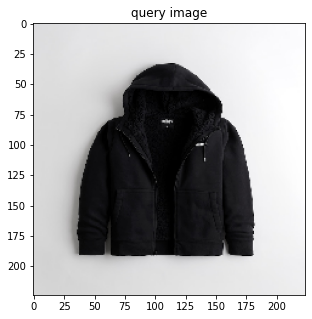

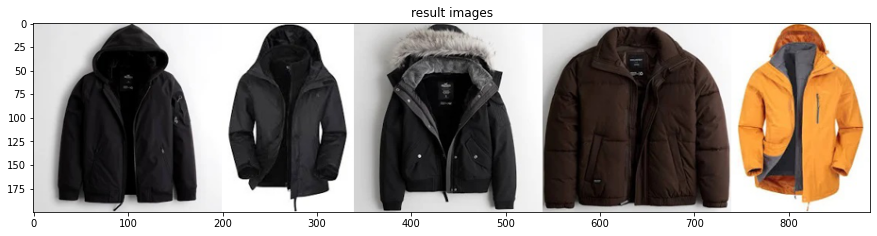

In [29]:




# project it into pca space
#new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_features, feat) for feat in pca_features ]
print(distances)
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5] 
print("testing")
 # grab first 5
print(idx_closest)
results_image = get_concatenated_images(idx_closest, 200)
#print(results_image)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (15,15))
plt.imshow(results_image)
plt.title("result images")

In [30]:
model.input_shape

(None, 224, 224, 3)

In [31]:
np.cumsum(pca.explained_variance_ratio_)

array([0.25721124, 0.3383223 , 0.40905583, 0.44874796, 0.47951624,
       0.5043263 , 0.52393603, 0.54237956, 0.5588076 , 0.5734627 ,
       0.5869536 , 0.6003232 , 0.6130315 , 0.6253714 , 0.63683087,
       0.6480011 , 0.6585664 , 0.6689489 , 0.67838144, 0.6875685 ,
       0.69654477, 0.70522743, 0.71321476, 0.7210481 , 0.72855574,
       0.7353849 , 0.74195427, 0.7483793 , 0.7546908 , 0.7608408 ,
       0.7668393 , 0.77255213, 0.77814007, 0.78358847, 0.7890246 ,
       0.79416406, 0.7992128 , 0.80416614, 0.8089126 , 0.81346875,
       0.817955  , 0.82222503, 0.8263192 , 0.83030343, 0.83426934,
       0.8381997 , 0.8420299 , 0.84578556, 0.84944427, 0.8530326 ,
       0.8565779 , 0.8600091 , 0.86337036, 0.8665836 , 0.869765  ,
       0.8728955 , 0.87598825, 0.8789479 , 0.8818522 , 0.88469565,
       0.88751096, 0.89024794, 0.8929459 , 0.8955459 , 0.8981074 ,
       0.90059775, 0.90308243, 0.9055066 , 0.9078745 , 0.9101808 ,
       0.91244763, 0.91467506, 0.9168736 , 0.9190127 , 0.92110

In [32]:
model.input_shape[1:3]

(224, 224)

In [33]:
features[0].shape

(4096,)

In [34]:
!pip install fastapi

In [35]:
from fastapi import FastAPI, Request
from fastapi.middleware.cors import CORSMiddleware
import base64
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=['*','http://localhost:3000'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

In [36]:
import base64
import io
from io import BytesIO

def get_concatenated_images1(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
      img = image.load_img(images[idx])
      buff = BytesIO()
      img.save(buff, format="JPEG")
      img_str = base64.b64encode(buff.getvalue())
      #print(img_str)
      thumbs.append(img_str)


        # img = io.BytesIO(image.load_img(images[idx]))
        # base64.b64encode(img)
       
        # img = str(base64.b64encode(img.resize((int(img.width * thumb_height / img.height), thumb_height))))
        # thumbs.append(img)
    return thumbs

In [37]:
get_concatenated_images1(idx_closest,200)


[b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAD8APwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD180ClooAUU6minUAOFOpop1AARmgDFBOKAc0AFKKSlFAC4o6UVHJIAvWgBWkCjNVZbkAk5qrc3qrn5q8x8b/EZtNlfTtJZXvh/rZWwVgz7d29u1AHoOqeItP0mLzb+9ht0PTzHwW+g6n8K4bV/jHZ2ysumWr3DdpJsxp+A

In [38]:
import io

def get_bytes_value(image):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    return img_byte_arr.getvalue()

In [39]:
from flask import jsonify
import json




In [40]:
from pydantic import BaseModel
class Item(BaseModel):
    item:str
    

In [41]:
import base64
from PIL import Image
from io import BytesIO
import re

@app.post("/temp")
async def return_images(request: Item):
  
  png_b64text = bytes(request.item,'utf-8')
  jpeg_recovered = base64.decodestring(png_b64text)
  f = open("temp8.jpeg", "wb")
  f.write(jpeg_recovered)
  f.close()
  

  new_image, x = load_image("temp8.jpeg")
  new_features = sim.predict(x)
  new_features = pca.transform(new_features)
  distances = [ distance.cosine(new_features, feat) for feat in pca_features ]
  idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5] 
  results_image = get_concatenated_images1(idx_closest, 200)

  ans1 = [str(i) for i in results_image]
  
  return ans1
  



In [42]:

#png_b64text6
return_images(png_b64text6)

<coroutine object return_images at 0x7fb978e4f3b0>

In [43]:
import cv2
import numpy as np

def save(encoded_data, filename):
    nparr = np.fromstring(encoded_data.decode('base64'), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)
    return cv2.imwrite(filename, img)

In [44]:
!pip install pyngrok
!pip install uvicorn

In [45]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

In [ ]:
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: http://f336-35-221-199-73.ngrok.io
